In [69]:
import re
import string 
import nltk 
from nltk.corpus import stopwords
from collections import defaultdict
from os import walk
import math
from matplotlib import pyplot as plt
import numpy as np

In [18]:
nltk.download('punkt')
nltk.download('stopwords')
ptbr_stopwords = stopwords.words('portuguese')

[nltk_data] Downloading package punkt to /Users/jramos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jramos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def to_lower(text):
    return " ".join([w.lower() for w in text.split()])

In [20]:
def remove_punctuation(text):
    clean_txt = "".join([c for c in text if c not in string.punctuation+'º'])
    return clean_txt

In [21]:
def add_space(text):
    return '<s> <s> ' + text + ' </s> </s>'

In [22]:
def remove_stopwords(text):
    phrase = " ".join([w.lower() for w in text.split() if w not in ptbr_stopwords])
    return phrase

In [23]:
def preprocess(text):
    text = re.sub('\n\n', '\n', text)
    text = re.findall('(?<=<TEXT>)[\s\S]*?(?=<\/TEXT>)', text)
    treated_corpus = [[] for i in range(len(text))]
    for i in range(len(text)):
        text_bl = re.findall('(?<=\\n)[\s\S]*?(?=\\n)', text[i])
        for j in range(len(text_bl)):
            text_bl[j] = re.sub('(^[\s])|([\s]$)','',text_bl[j])
            text_point = re.findall('[^\.]+', text_bl[j])
            for k in range(len(text_point)):
                text_comma = re.findall('[^\;]+', text_point[k])
                for l in range(len(text_comma)):
                    text_comma[l] = re.sub('([\d+])','',text_comma[l])
                    text_comma[l] = re.sub('(^[\s])|([\s]$)','',text_comma[l])
                    text_comma[l] = to_lower(text_comma[l])
                    text_comma[l] = remove_stopwords(text_comma[l])
                    text_comma[l] = remove_punctuation(text_comma[l])
                    text_comma[l] = add_space(text_comma[l])
                    treated_corpus[i].append(text_comma[l])
    
    return treated_corpus

In [24]:
def make_three_gram(text, three_gram):

    words = text.split()
    for i in range(len(words) - 2):
        if (words[i], words[i+1]) in three_gram.keys():
            if words[i + 2] in three_gram[(words[i], words[i+1])].keys():
                three_gram[(words[i], words[i+1])][words[i + 2]] += 1
            else:
                three_gram[(words[i], words[i+1])][words[i + 2]] = 1
        else:
            three_gram[(words[i], words[i+1])] = {words[i + 2] : 1}
    
    return three_gram

In [25]:
def make_bi_gram(text, bi_gram):
    
    words = text.split()
    for i in range(len(words) - 2):
        if (words[i+1]) in bi_gram.keys():
            if words[i + 2] in bi_gram[(words[i+1])].keys():
                bi_gram[(words[i+1])][words[i + 2]] += 1
            else:
                bi_gram[(words[i+1])][words[i + 2]] = 1
        else:
            bi_gram[(words[i+1])] = {words[i + 2] : 1}
    
    return bi_gram

In [26]:
def make_uni_gram(text, uni_gram):

    words = text.split()
    for i in range(len(words) - 2):
        if words[i+2] in uni_gram.keys():
            uni_gram[words[i + 2]] += 1
        else:
            uni_gram[words[i + 2]] = 1
    
    return uni_gram

In [54]:
def probability(w3, sentence, three_gram, bi_gram, uni_gram):
    w1, w2 = sentence
    
    #print("W1: ", w1)
    #print("W2: ", w2)
    #print("W3: ", w3)
    
    try: 
        three_gram_prob = three_gram[(w1,w2)][w3] / bi_gram[w1][w2]
        bi_gram_prob = bi_gram[(w1)][w2] / uni_gram[w2]
        uni_gram_prob = uni_gram[w3] / len(uni_gram)
        final_prob = 0.8 * three_gram_prob * 0.15 * bi_gram_prob * 0.05 * uni_gram_prob
        return final_prob
    except KeyError:
        return 0

In [29]:
def makeGrams(corpus):

    
    three_gram = defaultdict()
    bi_gram = defaultdict()
    uni_gram = defaultdict()
        
    for txt in corpus:
        for p in txt:
            make_three_gram(p, three_gram)

    for txt in corpus:
        for p in txt:
            bi_gram = make_bi_gram(p, bi_gram)


    for txt in corpus:
        for p in txt:
            uni_gram = make_uni_gram(p, uni_gram)
            
    return uni_gram, bi_gram, three_gram

In [106]:
def makeCorpus(folder_name, n_data=None):
    files_arr = []
    for _, _, files in walk('./{}/'.format(folder_name)):
        files_arr.extend(files)
        break
    
    corpus = []
    for file_name in files_arr[:n_data]:
        f = open('{}/{}'.format(folder_name,file_name), encoding='latin-1', mode='r')
        text = f.read()
        corpus = corpus + preprocess(text)
        
    return corpus

In [31]:
def makeGramMask(sentence, n_gram_lvl=0):
    return makeGrams([[sentence]])[n_gram_lvl]

In [110]:
train_corpus = makeCorpus('folha95', 100)
test_corpus = makeCorpus('folha94', 100)

In [112]:
train_uni_gram, train_bi_gram, train_three_gram = makeGrams(train_corpus)

In [113]:
test_uni_gram,test_bi_gram, test_three_gram = makeGrams(test_corpus)

In [114]:
perp_arr = {}
for text_tag in test_corpus:
    for sentence in text_tag:
        sentence_gram = makeGramMask(sentence, 2)
        #print(sentence)
        #print(sentence_gram)
        prob_sum = 0
        for word_tuple in sentence_gram.keys():
            for word in sentence_gram[word_tuple].keys():
                p = probability(word, word_tuple, train_three_gram, train_bi_gram, train_uni_gram)
                if p != 0:    
                    prob_sum = prob_sum + math.log(p)
        perp_arr[sentence] = math.exp(prob_sum)**(-1/float(len(sentence.split())))

In [115]:
len(perp_arr.keys())

269240

## Perplexidade Pura

### Análise
Abaixo está o grafico da perplexidade pura. É possivel identificar que existem perplexidades extreamente altas em comparação com o resto da distribuição.

O que parece influenciar esse pico na perplexidade é aparição de nomes nas sentenças.

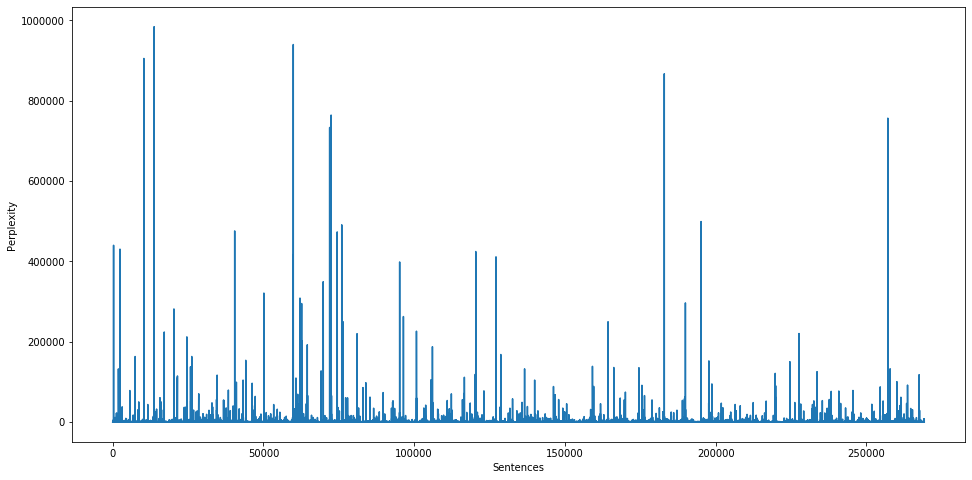

In [129]:
plt.figure(figsize=(16,8))
plt.xlabel('Sentences')
plt.ylabel('Perplexity')
plt.plot([i for i in range(len(perp_arr.keys()))], [perp_arr[k] for k in perp_arr.keys()])

In [144]:
ar = []
for k in perp_arr.keys():
    if perp_arr[k] > 500000:
        ar.append(k)